In [24]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../')
import utility as U

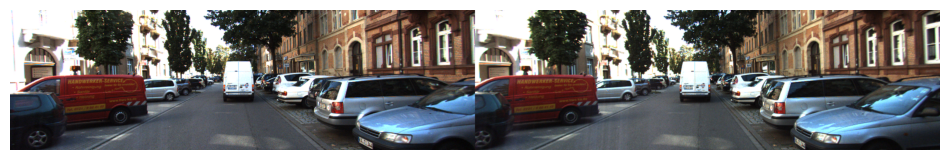

In [25]:
# Setting paths
datapath = "../data_scene_flow/training/"
left = "image_2/"
righ = "image_3/"
leftDataPath = datapath + left
rightDataPath = datapath + righ
file = "000005"
use_denoised_images = True

left_frame_path = leftDataPath + file + "_10.png"
right_frame_path = rightDataPath + file + "_10.png"

left_frame = cv2.imread(left_frame_path, cv2.IMREAD_GRAYSCALE)
left_frame_color = cv2.imread(left_frame_path)
right_frame = cv2.imread(right_frame_path, cv2.IMREAD_GRAYSCALE)
right_frame_color = cv2.imread(right_frame_path)

U.visualize_stereo_frames(left_frame_color, right_frame_color)

In [26]:
# calibration camera

# import the calibration matrix
calib_path = "../data_scene_flow_calib/training/calib_cam_to_cam/"
calib_file = calib_path + file + ".txt"

data_dict = {}

with open(calib_file, 'r') as f:
    lines = f.readlines()

for line in lines:
    line = line.strip()
    if line:
        key, value = line.split(': ')
        data_dict[key] = value

T0_2 = data_dict['T_02']
T0_2 = np.array([float(x) for x in T0_2.split(' ')])

T0_3 = data_dict['T_03']
T0_3 = np.array([float(x) for x in T0_3.split(' ')])

baseline = np.linalg.norm(T0_3 - T0_2)

print(T0_2)
print(T0_3)
print("baseline: ", baseline)

P0_2 = data_dict['P_rect_02']
P0_2 = np.array([float(x) for x in P0_2.split(' ')]).reshape(3, 4)

P0_3 = data_dict['P_rect_03']
P0_3 = np.array([float(x) for x in P0_3.split(' ')]).reshape(3, 4)

focal_length = P0_2[0, 0]
print("focal length: ", focal_length, " pixels")

[0.05956621 0.00029001 0.00257721]
[-0.473105    0.00555147 -0.00525088]
baseline:  0.532754708932503
focal length:  721.5377  pixels


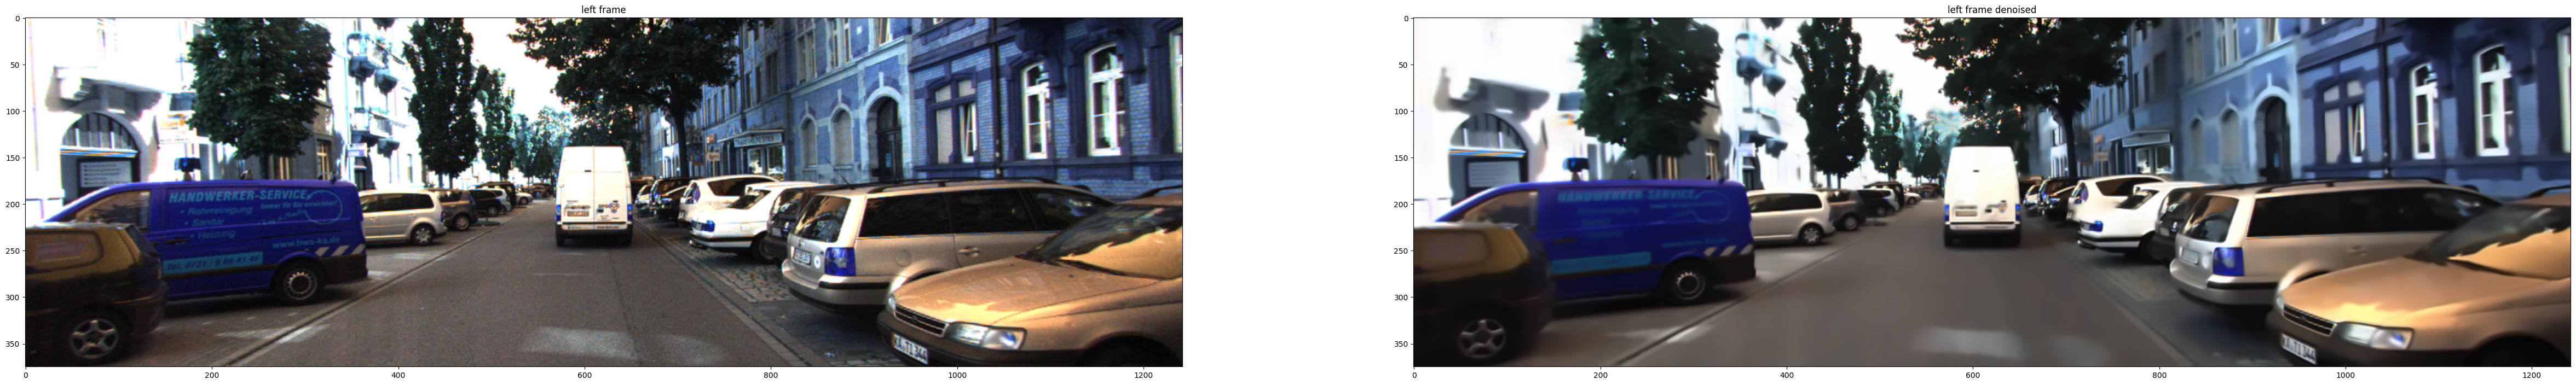

In [27]:
# Apply fastNlMeansDenoising to the grayscale image
if (use_denoised_images):

    left_frame_color_denoised = cv2.fastNlMeansDenoisingColored(left_frame_color, None, 15, 6, 7, 21)
    right_frame_color_denoised = cv2.fastNlMeansDenoisingColored(right_frame_color, None, 15, 6, 7, 21)

    # plot four images
    plt.figure(figsize=(60, 20))
    plt.subplot(2, 2, 1)
    plt.imshow(left_frame_color)
    plt.title('left frame')
    plt.subplot(2, 2, 2)
    plt.imshow(left_frame_color_denoised)
    plt.title('left frame denoised')

    plt.show()

In [28]:
# use the denoised images
if (use_denoised_images):
    left_frame_color = left_frame_color_denoised
    right_frame_color = right_frame_color_denoised

    left_frame = cv2.cvtColor(left_frame_color, cv2.COLOR_BGR2GRAY)
    right_frame = cv2.cvtColor(right_frame_color, cv2.COLOR_BGR2GRAY)

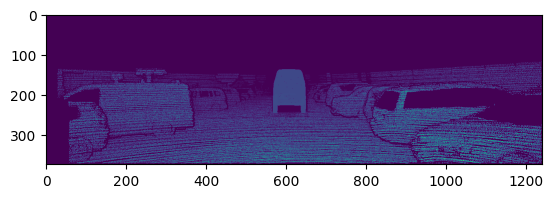

In [29]:
# import grand_trouth disparity map
gt_disparity_map_path = datapath + "disp_noc_0/" + file + "_10.png"

gt_disparity_map = cv2.imread(gt_disparity_map_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(gt_disparity_map)
plt.show()

In [30]:
max_disparity = gt_disparity_map.max()
print("max disparity: ", max_disparity)
min_disparity = gt_disparity_map.min()
print("min disparity: ", min_disparity)
shape = gt_disparity_map.shape
print("shape: ", shape)

# count the zero disparity
zero_disparity = gt_disparity_map == 0
zero_disparity = zero_disparity.astype(int)
zero_disparity = zero_disparity.sum()
print("zero disparity: ", zero_disparity)

# count the positive disparity
positive_disparity = gt_disparity_map > 0
positive_disparity = positive_disparity.astype(int)
positive_disparity = positive_disparity.sum()
print("positive disparity: ", positive_disparity)

max disparity:  101
min disparity:  0
shape:  (375, 1242)
zero disparity:  374624
positive disparity:  91126


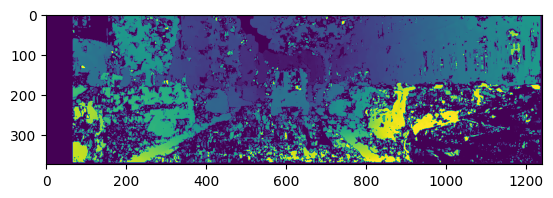

In [31]:
block_size = 9
num_disparities = 4 * 16

stereo = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=block_size)
cv_disparity = stereo.compute(left_frame, right_frame)
# remove negative values
cv_disparity = cv_disparity - cv_disparity.min()
plt.imshow(cv_disparity)
plt.show()

In [32]:
max_disparity = cv_disparity.max()
print("max disparity: ", max_disparity)
min_disparity = cv_disparity.min()
print("min disparity: ", min_disparity)
shape = cv_disparity.shape
print("shape: ", shape)

# count the negative disparity
negative_disparity = cv_disparity < 0
negative_disparity = negative_disparity.astype(int)
negative_disparity = negative_disparity.sum()
print("negative disparity: ", negative_disparity)

# count the zero disparity
zero_disparity = cv_disparity == 0
zero_disparity = zero_disparity.astype(int)
zero_disparity = zero_disparity.sum()
print("zero disparity: ", zero_disparity)

# count the positive disparity
positive_disparity = cv_disparity > 0
positive_disparity = positive_disparity.astype(int)
positive_disparity = positive_disparity.sum()
print("positive disparity: ", positive_disparity)


max disparity:  1024
min disparity:  0
shape:  (375, 1242)
negative disparity:  0
zero disparity:  200185
positive disparity:  265565


In [33]:
gt = False
if (gt):
    disparity_map = gt_disparity_map
else:
    disparity_map = cv_disparity
    
rows, columns = disparity_map.shape[0], disparity_map.shape[1]

# finding the center of the image
u0 = columns / 2 
v0 = rows / 2

vertices = []
colors = []

for i in range(columns):
    for j in range(rows):
        
        d = disparity_map[j][i] / columns
        color = left_frame_color[j,i]

        if d==0:
            continue
        else:
            z = focal_length * (baseline / d)
            x = ((i-u0)) * (z / focal_length)
            y = - ((j-v0)) * (z / focal_length)
            
            if z>0:
                vertices.append(np.array([x,y,-z]))
                colors.append(np.array(color / 255.0))


vertices = np.stack(vertices)
colors = np.stack(colors)


In [34]:
vertices_shape = vertices.shape
print("vertices shape: ", vertices_shape)
colors_shape = colors.shape
print("colors shape: ", colors_shape)

vertices shape:  (265565, 3)
colors shape:  (265565, 3)


DBSACN

parameters : (eps,min_samples)

eps: είναι η μέγιστη απόσταση μεταξύ δύο δειγμάτων για να θεωρηθούν γείτονες.
min_samples: είναι ο ελάχιστος αριθμός σημείων που πρέπει να βρίσκονται μέσα στην σφαίρα με ακίνα ίση με την μέγιστη απόστααση eps και κέντρο ένα σημείο P ώστε το P να θεωρηθεί core point.

In [35]:
if not gt:
    from sklearn.cluster import DBSCAN

    # clustering
    # eps = 55
    # min_samples = 400

    labels = DBSCAN(55,min_samples=400).fit(vertices)
    labels = labels.labels_
    vertices = vertices[labels > -1]
    colors = colors[labels>-1]
    vertices_shape = vertices.shape
    print("vertices shape: ", vertices_shape)
    colors_shape = colors.shape
    print("colors shape: ", colors_shape)


vertices shape:  (188306, 3)
colors shape:  (188306, 3)


In [36]:
# save vertices
if not gt:
    np.save("../pointcloud/vertices.npy", vertices)
    np.save("../pointcloud/colors.npy", colors)
elif gt:
    np.save("../pointcloud/gt_vertices.npy", vertices)
    np.save("../pointcloud/gt_colors.npy", colors)